In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt


warnings.filterwarnings("ignore")


DIR_INPUT = ''
DIR_TRAIN = '\train'
DIR_TEST = '\test'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}train.csv')
train_df.fillna(0, inplace=True)
train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

# FasterRCNN handles class_id==0 as the background.
train_df["class_id"] = train_df["class_id"] + 1
train_df.loc[train_df["class_id"] == 15, ["class_id"]] = 0

train_df.shape
train_df.sort_values(by='image_id').head(20)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
65515,000434271f63a053c4128a0ba6352c7f,No finding,0,R3,0.0,0.0,1.0,1.0
56742,000434271f63a053c4128a0ba6352c7f,No finding,0,R2,0.0,0.0,1.0,1.0
689,000434271f63a053c4128a0ba6352c7f,No finding,0,R6,0.0,0.0,1.0,1.0
62487,00053190460d56c53cc3e57321387478,No finding,0,R7,0.0,0.0,1.0,1.0
19324,00053190460d56c53cc3e57321387478,No finding,0,R2,0.0,0.0,1.0,1.0
11114,00053190460d56c53cc3e57321387478,No finding,0,R11,0.0,0.0,1.0,1.0
13648,0005e8e3701dfb1dd93d53e2ff537b6e,Nodule/Mass,9,R8,932.0,567.0,1197.0,896.0
15180,0005e8e3701dfb1dd93d53e2ff537b6e,Infiltration,7,R10,900.0,587.0,1205.0,888.0
16938,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,8,R9,905.0,583.0,1203.0,890.0
664,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,8,R10,900.0,587.0,1205.0,888.0


In [3]:
# train_df["class_id"].value_counts()
train_df["class_id"].nunique()

15

In [4]:
sample_id = "000434271f63a053c4128a0ba6352c7f"
#image = Image.open(f"{DIR_TRAIN}\{sample_id}.jpg")
#print(os.path.join("train",f"{sample_id}.jpg"))
dicom = pydicom.dcmread(os.path.join("train",f"{sample_id}.dicom"))
#dicom = pydicom.dcmread(f"{DIR_TRAIN}\{sample_id}.dicom")
dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 000434271f63a053c4128a0ba6352c7f
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'O'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 2836
(0028, 0011) Columns                             US: 2336
(0028, 0030) Pixel Spacing            

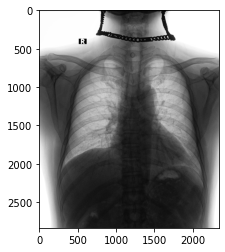

In [5]:
image = dicom.pixel_array * dicom.RescaleSlope + dicom.RescaleIntercept

plt.imshow(image, cmap='gray')

In [6]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-3000:]
train_ids = image_ids[:-3000]
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]
valid_df.shape, train_df.shape

((9590, 8), (58324, 8))

In [7]:
class VinBigDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)
        
        #print(os.path.join("train",f"{image_id}.jpg"))
        #image = Image.open(os.path.join("train",f"{image_id}.jpg"))
        #plt.imshow(image, cmap='gray')
        dicom = pydicom.dcmread(os.path.join("train",f"{image_id}.dicom"))
        
        image = dicom.pixel_array
        
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image
        
        intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
        slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)        
        
        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        image = image.transpose(1,2,0)
        
        
        if records.loc[0, "class_id"] == 0:
            records = records.loc[[0], :]
        
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        #print(boxes)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.tensor(sample['bboxes'])

        if target["boxes"].shape[0] == 0:
            # Albumentation cuts the target (class 14, 1x1px in the corner)
            target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]]))
            target["area"] = torch.tensor([1.0], dtype=torch.float32)
            target["labels"] = torch.tensor([0], dtype=torch.int64)
            
        return image, target
    
    def __len__(self):
        return self.image_ids.shape[0]

In [8]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [9]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [10]:
num_classes = 15

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VinBigDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = VinBigDataset(valid_df, DIR_TRAIN, get_valid_transform())

train_dataset[5]
# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


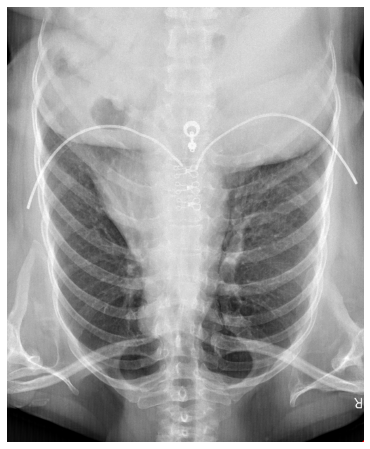

In [13]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [13]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [14]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs = 12

In [15]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 100 == 0:
            print(f"Iteration #{itr} loss: {loss_hist.value}")

        itr += 1
        
        # !!!REMOVE THIS!!!
        break
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    print("Saving epoch's state...")
    torch.save(model.state_dict(), f"model_state_epoch_{epoch}.pth")

RuntimeError: CUDA out of memory. Tried to allocate 508.00 MiB (GPU 0; 11.00 GiB total capacity; 7.56 GiB already allocated; 60.88 MiB free; 8.91 GiB reserved in total by PyTorch)

In [17]:
images, targets = next(iter(valid_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

TypeError: Expected Ptr<cv::UMat> for argument 'img'

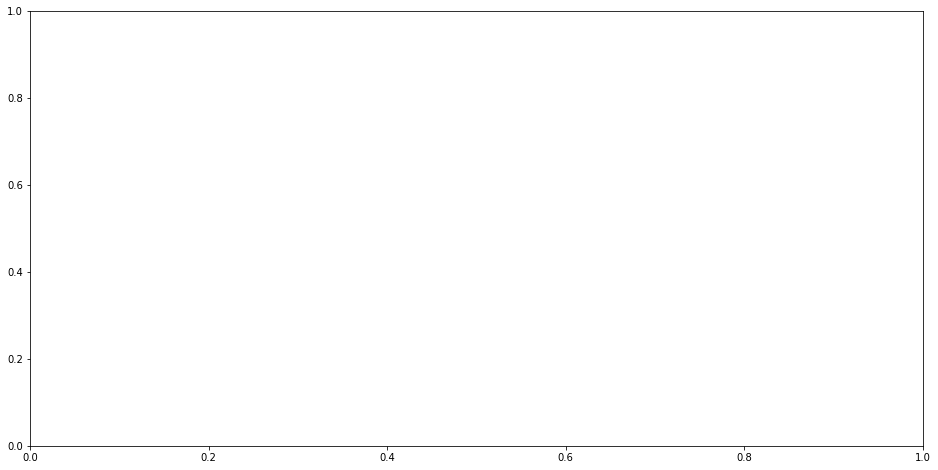

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

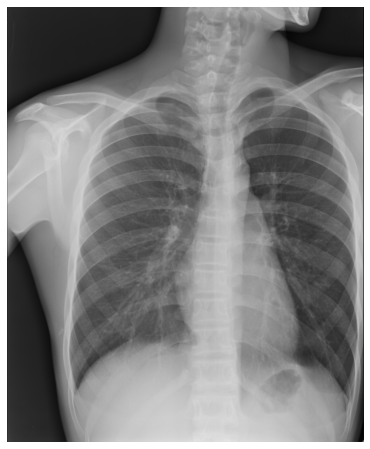

In [25]:
sample = images[0].permute(1,2,0).cpu().numpy()
boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()

#boxes = boxes[scores >= detection_threshold].astype(np.int32)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [23]:
len(images)

8